In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# import all the required library
import cv2
import os 
import numpy as np
import matplotlib
from imutils import paths
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_blobs

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.utils import plot_model
from keras import backend as K

In [ ]:
class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        # store the target image width, height, and interpolation
        # method used when resizing
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        # resize the image to a fixed size, ignoring the aspect ratio
        return cv2.resize(image, (self.width, self.height),interpolation=self.inter)

In [ ]:
class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
        #store the image preprocessors
        self.preprocessors = preprocessors

        #if the preprocessors are none initialize as an empty list
        if self.preprocessors is None:
            self.preprocessors = []
            
    def load(self, imagePaths, verbose = -1):
        #initialize the list of fearures nad labels 
        data = []
        labels = []
        
        #loop over the input iamges
        for(i, imagePath) in enumerate(imagePaths):
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]
#             print(label)
            if self.preprocessors is not None:
                #loop over the preprocessors and apply each to the image
                for p in self.preprocessors:
                    image = p.preprocess(image)
            # treat our processed image as a "feature vector"
            #by updating the data list followed by the labels
            data.append(image)
            labels.append(label)
            
            if verbose > 0 and i >0 and (i+1) % verbose ==0:
                print("[INFO] processed {}/{}".format(i+1, len(imagePaths)))
                
        return (np.array(data), np.array(labels))

In [ ]:

# initialize the image preprocessor, load the dataset from disk,
# and reshape the data matrix
sp = SimplePreprocessor(32, 32)
sdl = SimpleDatasetLoader(preprocessors=[sp])
lb = LabelBinarizer()

In [ ]:
# grab the list of images that we’ll be describing
print("[INFO] loading images...")
loc = list(paths.list_images("locust/"))
(X, Y) = sdl.load(loc, verbose=500)
Y = lb.fit_transform(Y)
Y = np.reshape(Y,(76,1))
X = X.astype("float") / 255.0

In [ ]:
# Encoding categorical data
# Encoding the Independent Variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
lab_y = OneHotEncoder()
onehotencoder = OneHotEncoder(categorical_features = [0])
Y = onehotencoder.fit_transform(Y).toarray()
Y.shape

In [ ]:
from sklearn.model_selection import train_test_split
XTr, XTs, yTr, yTs = train_test_split(X,Y, test_size=0.20, random_state=42)

In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, 
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [ ]:
class MiniVGGNet:
    @staticmethod
    def build (width, height, depth, classes):
        model=Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
        model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        
        model.add(Conv2D(32, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        
        model.add(MaxPooling2D(pool_size =(2,2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        
        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        
        model.add(MaxPooling2D(pool_size =(2,2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        return model

In [ ]:
# initialize the optimizer and model

print("[INFO] compiling model...")
opt = SGD(lr=0.01, decay=0.01 / 40, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=2)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] model summary")
model.summary()

In [19]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
fname = os.path.sep.join(["weights",
 "weights-{epoch:03d}-{val_loss:.4f}.hdf5"])

In [20]:
checkpoint = ModelCheckpoint(fname, monitor="val_loss", mode="min",
save_best_only=True, verbose=1)
callbacks = [checkpoint]

In [22]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(aug.flow(XTr, yTr, batch_size=2),
                        validation_data=(XTs, yTs), steps_per_epoch=len(XTr) // 32,
                        epochs=40, verbose=1)

[INFO] training network...
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.7106 - accuracy: 0.5000 - val_loss: 1.5700 - val_accuracy: 0.8125
Epoch 2/40
1/1 [==============================] - 0s 179ms/step - loss: 0.7713 - accuracy: 0.5000 - val_loss: 3.0221 - val_accuracy: 0.8125
Epoch 3/40
1/1 [==============================] - 0s 173ms/step - loss: 0.6173 - accuracy: 0.5000 - val_loss: 3.0221 - val_accuracy: 0.8125
Epoch 4/40
1/1 [==============================] - 0s 172ms/step - loss: 2.4703 - accuracy: 0.0000e+00 - val_loss: 3.0221 - val_accuracy: 0.8125
Epoch 5/40
1/1 [==============================] - 0s 193ms/step - loss: 2.3989 - accuracy: 0.5000 - val_loss: 3.0221 - val_accuracy: 0.8125
Epoch 6/40
1/1 [==============================] - 0s 165ms/step - loss: 1.0589 - accuracy: 0.5000 - val_loss: 13.0960 - val_accuracy: 0.1875
Epoch 7/40
1/1 [==============================] - 0s 200ms/step - loss: 3.4061 - ac

In [23]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(XTs, batch_size=16)
print(classification_report(yTs.argmax(axis=1),
                            predictions.argmax(axis=1), 
                            target_names=[str(x) for x in lb.classes_]))


[INFO] evaluating network...
              precision    recall  f1-score   support

   dangerous       0.00      0.00      0.00        13
      normal       0.19      1.00      0.32         3

    accuracy                           0.19        16
   macro avg       0.09      0.50      0.16        16
weighted avg       0.04      0.19      0.06        16



plot the training loss and accuracy


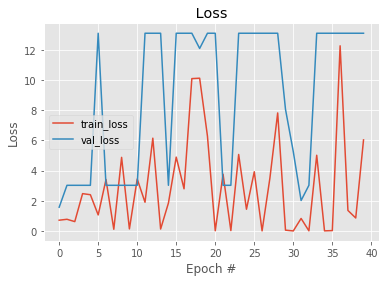

In [24]:
%matplotlib inline
print("plot the training loss and accuracy")
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.title(" Loss ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

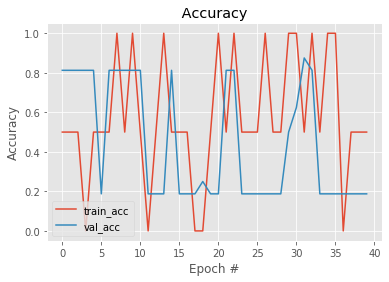

In [25]:
%matplotlib inline
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_accuracy"], label="val_acc")
plt.title(" Accuracy ")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [41]:
model.save('model/model')

In [38]:
im = cv2.imread('index.jpeg')
im = cv2.resize(im, (32,32))
im = np.reshape(im, (1,32,32,3))
model.predict_classes(im)

array([1])

In [32]:
im.shape

(32, 32, 3)